# 머신러닝의 한계점
* 인사이트
>1. R^2 값이 0.98이라고 하더라도 상황에 따라 전혀 안 좋은 성능일 수 있다.
>2. 오차를 최대한 줄이려고 하는 모델 특성상 어떻게 학습했는지 잘 살펴봐야 한다.올라감
* 한계점 극복
>* 분류 모델로 학습 (상승 or 하강)
>* 풍부한 데이터를 위해 10일치씩 묶어서 학습

## 1) 데이터 로드 및 전처리

In [3]:
!pip install Finance-DataReader # 여러 금융 데이터 제공 (한국 주식 포함)

In [4]:
import FinanceDataReader as fdr
import matplotlib.pyplot as plt

* 데이터 탐색
>* Open: 시가, High: 고가, Low: 저가, Close: 종가, Volume: 거래량, Adj Close: 수정 종가
>* 문제집: N일의 Open, High, Low, Close, Volume
>* 정답지: N+1일의 Close

In [8]:
df = fdr.DataReader('AAPL') # 애플: AAPL, 삼성전자: 005930
df

,Open,High,Low,Close,Volume,Adj Close
1980-12-12,0.128348,0.128906,0.128348,0.128348,469033600,0.098597
1980-12-15,0.122210,0.122210,0.121652,0.121652,175884800,0.093453
1980-12-16,0.113281,0.113281,0.112723,0.112723,105728000,0.086594
1980-12-17,0.115513,0.116071,0.115513,0.115513,86441600,0.088737
1980-12-18,0.118862,0.119420,0.118862,0.118862,73449600,0.091310
...,...,...,...,...,...,...
2025-08-04,204.509995,207.880005,201.679993,203.350006,75109300,203.350006
2025-08-05,203.399994,205.339996,202.160004,202.919998,44155100,202.919998
2025-08-06,205.630005,215.380005,205.589996,213.250000,108483100,213.250000
2025-08-07,218.880005,220.850006,216.580002,220.029999,90224800,220.029999


* 데이터 전처리
>1. 수정 종가 열 삭제
>2. 데이터 분할
>3. 데이터셋(문제집/정답지) 생성

In [9]:
# 1. 수정 종가 열 삭제
del df['Adj Close']

In [10]:
# 2. 데이터 분할
train = df[df.index.year<=2023] # 훈련 데이터: 옛날 ~ 2023년
test = df[df.index.year>2023] # 시험 데이터: 2024년 ~ 현재

In [11]:
# 3. 데이터셋(문제집/정답지) 생성
train_x = []
train_y = []
for i in range(len(train) - 1):
    x = train.iloc[i].values # i번째 행의 모든 열
    y = train.iloc[i+1, 3]   # i+1번째 행의 Close 열
    train_x.append(x)
    train_y.append(y)

test_x = []
test_y = []
for i in range(len(test) - 1):
    x = test.iloc[i].values # i번째 행의 모든 열
    y = test.iloc[i+1, 3]   # i+1번째 행의 Close 열
    test_x.append(x)
    test_y.append(y)

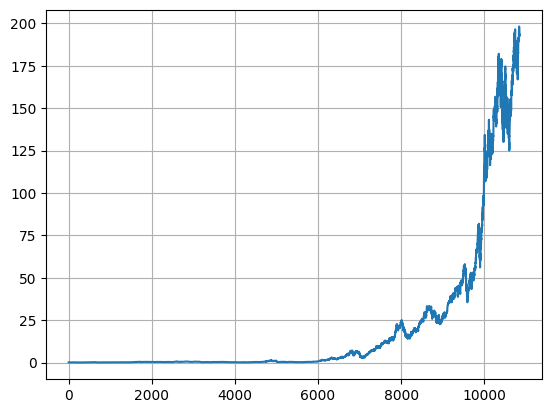

In [12]:
# 훈련 데이터 시각화
plt.plot(train_y)
plt.grid()
plt.show()

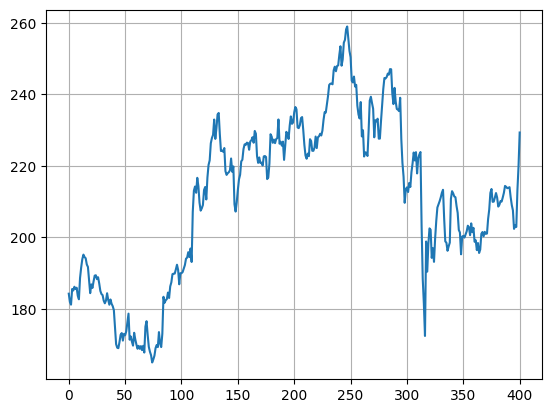

In [13]:
# 시험 데이터 시각화
plt.plot(test_y)
plt.grid()
plt.show()

## 2. 모델링
* 회귀 모델
>* 표준화 필요 없음

In [14]:
from sklearn.ensemble import RandomForestRegressor

### 1) 기본 모델
* score가 음수 → 전혀 예측을 하지 못함

In [16]:
model = RandomForestRegressor()
model.fit(train_x, train_y)
model.score(test_x, test_y) # -0.21259921811263105

-0.21259921811263105

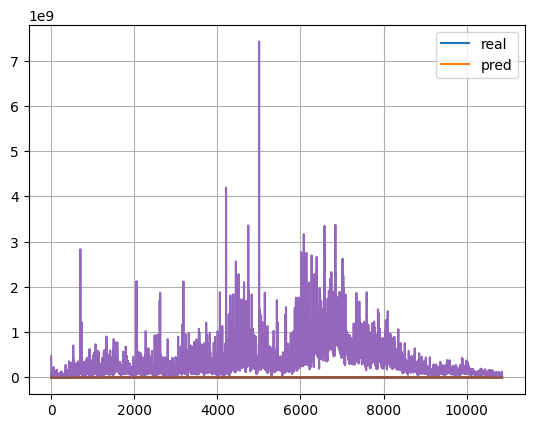

In [18]:
pred = model.predict(train_x)

plt.plot(train_x)
plt.plot(pred)
plt.legend(['real', 'pred'])
plt.grid()
plt.show()

* 주가는 계속 상승했는데, 훈련 데이터는 과거 데이터고 시험 데이터는 최신 데이터라 예측 범위 자체를 넘어감
* randomforest는 훈련 받지 않은 범위는 예측을 전혀 하지 못함 → 선형 회귀 모델을 쓰는 것이 조금은 더 적합

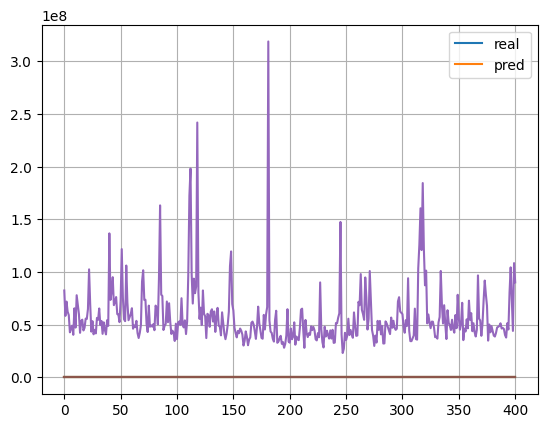

In [19]:
pred = model.predict(test_x)

plt.plot(test_x)
plt.plot(pred)
plt.legend(['real', 'pred'])
plt.grid()
plt.show()

### 삼성전자

* 삼성전자로 모델 학습하면 0.98이상 나오는데 이건 좋은 수치가 아님!
* 삼성전자 주식 자체가 하루에 1% 이하로 증가/감소 하는데 2%가 틀리면 다 틀리는 것!
⇒ 절대 좋은 모델이 아님!!
---
* 시험 데이터 그래프를 그려보면 예측을 잘 하는 것처럼 보임 (경향을 잘 따라감)
* 그러나 자세히 보면 오른쪽으로 조금씩만 이동한 것
* 즉, 예측을 그냥 전날 가격으로 해버림 (어차피 큰 차이가 없으니까!)

R2 score : 0.9819470587485054


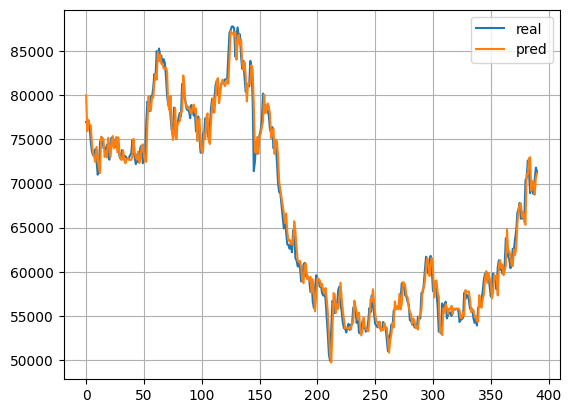

In [28]:
df = fdr.DataReader('005930').dropna()

train = df[df.index.year<=2023]
test = df[df.index.year>2023]

train_x = []
train_y = []
for i in range(len(train) - 1):
    x = train.iloc[i].values
    y = train.iloc[i+1, 3]
    train_x.append(x)
    train_y.append(y)

test_x = []
test_y = []
for i in range(len(test) - 1):
    x = test.iloc[i].values
    y = test.iloc[i+1, 3]
    test_x.append(x)
    test_y.append(y)

model = RandomForestRegressor()
model.fit(train_x, train_y)
print('R2 score :', model.score(test_x, test_y))

pred = model.predict(test_x)

plt.plot(test_y)
plt.plot(pred)
plt.legend(['real', 'pred'])
plt.grid()
plt.show()

# 한계점 극복
* 분류 모델 사용 → 종목 예측
* input: 10일 데이터, output: 다음날 종가
---
* 회사의 주식 종목 대신 ETF(여러 개의 종목을 묶어 놓은 것) 추천


In [5]:
from tqdm import tqdm

In [6]:
etfs = fdr.StockListing('ETF/KR')
etfs

,Symbol,Category,Name,Price,RiseFall,Change,ChangeRate,NAV,EarningRate,Volume,Amount,MarCap
0,459580,6,KODEX CD금리액티브(합성),1074285,2,75,0.01,1074299.0,0.6557,167206,179626,89262
1,360750,4,TIGER 미국S&P500,22040,2,155,0.71,22013.0,11.6524,7180144,158286,88898
2,069500,1,KODEX 200,43455,2,10,0.02,43476.0,27.2815,4789121,208292,69419
3,488770,7,KODEX 머니마켓액티브,103515,2,10,0.01,103517.0,0.7495,428207,44324,68756
4,133690,4,TIGER 미국나스닥100,145460,2,1030,0.71,145378.0,16.2798,277483,40383,55304
...,...,...,...,...,...,...,...,...,...,...,...,...
1000,465620,4,ACE 미국빅테크TOP7 Plus인버스(합성),8715,5,-115,-1.30,8683.0,-20.0182,6796,58,22
1001,145670,3,ACE 인버스,4335,5,-5,-0.12,4340.0,-21.3769,17293,74,22
1002,275750,3,RISE 코스닥150선물인버스,3420,5,-25,-0.73,3413.0,-12.6743,7892,26,21
1003,412560,2,TIGER BBIG레버리지,2250,2,50,2.27,2229.0,33.7386,2780,6,16


In [7]:
etfs_dic = {}

for i in tqdm(range(len(etfs))):
    try:
        row = etfs.iloc[i]
        symbol = row['Symbol']
        name = row['Name']
        df = fdr.DataReader(symbol)

        etfs_dic[symbol] = [name, df]
    except:
        continue

100%|██████████| 1005/1005 [14:46<00:00,  1.13it/s]


In [29]:
etfs_dic

{'459580': ['KODEX CD금리액티브(합성)',
                 Open     High      Low    Close  Volume    Change
  Date                                                            
  2023-06-08   998936   998936   998926   998931    6890       NaN
  2023-06-09   998930   999210   998920   999210    8942  0.000279
  2023-06-12   999365   999365   999355   999365    6670  0.000155
  2023-06-13   999410   999410   999400   999410    5914  0.000045
  2023-06-14   999510   999510   999495   999510    8291  0.000100
  ...             ...      ...      ...      ...     ...       ...
  2025-08-05  1073840  1073845  1073840  1073845  148793  0.000070
  2025-08-06  1073915  1073920  1073915  1073920  217354  0.000070
  2025-08-07  1074130  1074135  1074130  1074135  182051  0.000200
  2025-08-08  1074205  1074210  1074205  1074210  140472  0.000070
  2025-08-11  1074280  1074285  1074280  1074285  152341  0.000070
  
  [531 rows x 6 columns]],
 '360750': ['TIGER 미국S&P500',
               Open   High    Low  C

In [30]:
len(etfs_dic)

906

In [32]:
# 하루에 5% 이상 급등하는 종목 (성능 65% 정도) → 1% 변화하는 종목은 너무 많기도 하고 이유 없이 변화할 수 있는 수치
for symbol in etfs_dic:
    name = etfs_dic[symbol][0]
    df = etfs_dic[symbol][1].copy().dropna()
    print(df)
    break

               Open     High      Low    Close  Volume    Change
Date                                                            
2023-06-09   998930   999210   998920   999210    8942  0.000279
2023-06-12   999365   999365   999355   999365    6670  0.000155
2023-06-13   999410   999410   999400   999410    5914  0.000045
2023-06-14   999510   999510   999495   999510    8291  0.000100
2023-06-15   999610   999610   999600   999610   35493  0.000100
...             ...      ...      ...      ...     ...       ...
2025-08-05  1073840  1073845  1073840  1073845  148793  0.000070
2025-08-06  1073915  1073920  1073915  1073920  217354  0.000070
2025-08-07  1074130  1074135  1074130  1074135  182051  0.000200
2025-08-08  1074205  1074210  1074205  1074210  140472  0.000070
2025-08-11  1074280  1074285  1074280  1074285  152341  0.000070

[530 rows x 6 columns]


In [34]:
# 일단은 하루치 데이터만 input
X = []
Y = []

for symbol in etfs_dic:
    name = etfs_dic[symbol][0]
    df = etfs_dic[symbol][1].copy().dropna()

    for i in range(len(df)-1):
        x = df.iloc[i].values
        before = df.iloc[i, 3]
        after = df.iloc[i+1, 3]
        y = (after - before) / before * 100 # 전날 대비 상승 %
        print(y)

        if i==10:
            break
    break

0.015512254681198146
0.0045028593156654475
0.010005903483055002
0.010004902402177067
0.030411860625644
0.017001462125742814
0.002999748021166222
0.0068992134896621775
0.013997438468760217
0.03138986107487282
0.013991087677149655


In [35]:
X = []
Y = []

for symbol in etfs_dic:
    name = etfs_dic[symbol][0]
    df = etfs_dic[symbol][1].copy().dropna()

    for i in range(len(df)-1):
        x = df.iloc[i].values
        before = df.iloc[i, 3]
        after = df.iloc[i+1, 3]
        y = (after - before) / before * 100 >= 5
        print(y)

        if i==10:
            break
    break

False
False
False
False
False
False
False
False
False
False
False


In [37]:
X = []
Y = []

for symbol in tqdm(etfs_dic):
    name = etfs_dic[symbol][0]
    df = etfs_dic[symbol][1].copy().dropna()

    for i in range(len(df)-1):
        x = df.iloc[i].values
        before = df.iloc[i, 3]
        after = df.iloc[i+1, 3]
        y = (after - before) / before * 100 >= 5

        X.append(x)
        Y.append(y)

100%|██████████| 906/906 [02:54<00:00,  5.18it/s]


In [38]:
len(X)

1148551

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [40]:
# 데이터 분할
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2)

# 모델 학습
model = RandomForestClassifier()
model.fit(train_x, train_y)

# 모델 예측
pred = model.predict(test_x)

# 성능 평가
report = classification_report(test_y, pred)
print(report)

              precision    recall  f1-score   support

       False       0.99      1.00      1.00    228405
        True       0.52      0.03      0.06      1306

    accuracy                           0.99    229711
   macro avg       0.76      0.52      0.53    229711
weighted avg       0.99      0.99      0.99    229711



In [41]:
from xgboost import XGBClassifier

# 모델 학습
model = XGBClassifier()
model.fit(train_x, train_y)

# 모델 예측
pred = model.predict(test_x)

# 성능 평가
report = classification_report(test_y, pred)
print(report)

              precision    recall  f1-score   support

       False       0.99      1.00      1.00    228405
        True       0.24      0.03      0.06      1306

    accuracy                           0.99    229711
   macro avg       0.62      0.52      0.53    229711
weighted avg       0.99      0.99      0.99    229711



In [8]:
# 10일치 데이터 input
X = []
Y = []

window = 10

for symbol in tqdm(etfs_dic):
    name = etfs_dic[symbol][0]
    df = etfs_dic[symbol][1].copy().dropna()

    for i in range(len(df)-window):
        x = df.iloc[i:i+window].values.flatten()
        before = df.iloc[i+window-1, 3]
        after = df.iloc[i+window, 3]
        y = (after - before) / before * 100 >= 5

        X.append(x)
        Y.append(y)

100%|██████████| 906/906 [03:14<00:00,  4.67it/s]


In [11]:
# 데이터 분할
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2)

In [12]:
from xgboost import XGBClassifier

# 모델 학습
model = XGBClassifier()
model.fit(train_x, train_y)

# 모델 예측
pred = model.predict(test_x)

# 성능 평가
report = classification_report(test_y, pred)
print(report)

              precision    recall  f1-score   support

       False       1.00      1.00      1.00    226752
        True       0.67      0.19      0.30      1328

    accuracy                           0.99    228080
   macro avg       0.83      0.60      0.65    228080
weighted avg       0.99      0.99      0.99    228080



In [ ]:
# 모델 학습
model = RandomForestClassifier()
model.fit(train_x, train_y)

# 모델 예측
pred = model.predict(test_x)

# 성능 평가
report = classification_report(test_y, pred)
print(report)

In [13]:
# 전체 데이터 재학습
model.fit(X, Y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [14]:
# etf 종목 추천
for symbol in etfs_dic:
    name = etfs_dic[symbol][0]
    df = etfs_dic[symbol][1].copy().dropna().iloc[-window:].values.flatten()

    pred = model.predict([df])[0]

    if pred==1:
        print(name)

In [15]:
# 10일치 데이터 input
X = []
Y = []

window = 10

for symbol in tqdm(etfs_dic):
    name = etfs_dic[symbol][0]
    df = etfs_dic[symbol][1].copy().dropna()

    for i in range(len(df)-window):
        x = df.iloc[i:i+window].values.flatten()
        before = df.iloc[i+window-1, 3]
        after = df.iloc[i+window, 3]
        y = (after - before) / before * 100 >= 4

        X.append(x)
        Y.append(y)

# 데이터 분할
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2)

# 모델 학습
model = XGBClassifier()
model.fit(train_x, train_y)

# 모델 예측
pred = model.predict(test_x)

# 성능 평가
report = classification_report(test_y, pred)
print(report)

model.fit(X, Y)

for symbol in etfs_dic:
    name = etfs_dic[symbol][0]
    df = etfs_dic[symbol][1].copy().dropna().iloc[-window:].values.flatten()

    pred = model.predict([df])[0]

    if pred==1:
        print(name)

100%|██████████| 906/906 [03:14<00:00,  4.66it/s]


              precision    recall  f1-score   support

       False       0.99      1.00      0.99    225517
        True       0.68      0.15      0.25      2563

    accuracy                           0.99    228080
   macro avg       0.83      0.58      0.62    228080
weighted avg       0.99      0.99      0.99    228080



In [16]:
# 10일치 데이터 input
X = []
Y = []

window = 10

for symbol in tqdm(etfs_dic):
    name = etfs_dic[symbol][0]
    df = etfs_dic[symbol][1].copy().dropna()

    for i in range(len(df)-window):
        x = df.iloc[i:i+window].values.flatten()
        before = df.iloc[i+window-1, 3]
        after = df.iloc[i+window, 3]
        y = (after - before) / before * 100 >= 3

        X.append(x)
        Y.append(y)

# 데이터 분할
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2)

# 모델 학습
model = XGBClassifier()
model.fit(train_x, train_y)

# 모델 예측
pred = model.predict(test_x)

# 성능 평가
report = classification_report(test_y, pred)
print(report)

model.fit(X, Y)

for symbol in etfs_dic:
    name = etfs_dic[symbol][0]
    df = etfs_dic[symbol][1].copy().dropna().iloc[-window:].values.flatten()

    pred = model.predict([df])[0]

    if pred==1:
        print(name)

100%|██████████| 906/906 [03:08<00:00,  4.81it/s]


              precision    recall  f1-score   support

       False       0.98      1.00      0.99    222534
        True       0.67      0.10      0.18      5546

    accuracy                           0.98    228080
   macro avg       0.83      0.55      0.58    228080
weighted avg       0.97      0.98      0.97    228080



In [17]:
# 10일치 데이터 input
X = []
Y = []

window = 10

for symbol in tqdm(etfs_dic):
    name = etfs_dic[symbol][0]
    df = etfs_dic[symbol][1].copy().dropna()

    for i in range(len(df)-window):
        x = df.iloc[i:i+window].values.flatten()
        before = df.iloc[i+window-1, 3]
        after = df.iloc[i+window, 3]
        y = (after - before) / before * 100 >= 2

        X.append(x)
        Y.append(y)

# 데이터 분할
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2)

# 모델 학습
model = XGBClassifier()
model.fit(train_x, train_y)

# 모델 예측
pred = model.predict(test_x)

# 성능 평가
report = classification_report(test_y, pred)
print(report)

model.fit(X, Y)

print('** 종목 추천 **')
for symbol in etfs_dic:
    name = etfs_dic[symbol][0]
    df = etfs_dic[symbol][1].copy().dropna().iloc[-window:].values.flatten()

    pred = model.predict([df])[0]

    if pred==1:
        print(name)

100%|██████████| 906/906 [03:14<00:00,  4.66it/s]


              precision    recall  f1-score   support

       False       0.94      1.00      0.97    214367
        True       0.72      0.08      0.14     13713

    accuracy                           0.94    228080
   macro avg       0.83      0.54      0.55    228080
weighted avg       0.93      0.94      0.92    228080

** 종목 추천 **


* 팁
>* ~~~레버리지 -> 안 사는 편
>* 삼성전자, 코카콜라, 마이크로소프트 등 안전한 종목 추천 -> 사는 편 (예측이 맞으면 바로 팔고, 틀려도 언젠가 오를테니까 기다림)

In [18]:
# 10일치 데이터 input
X = []
Y = []

window = 10

for symbol in tqdm(etfs_dic):
    name = etfs_dic[symbol][0]
    df = etfs_dic[symbol][1].copy().dropna()

    for i in range(len(df)-window):
        x = df.iloc[i:i+window].values.flatten()
        before = df.iloc[i+window-1, 3]
        after = df.iloc[i+window, 3]
        prob = (after - before) / before * 100
        y = 0 if prob<1 else (1 if prob<2 else (2 if prob<3 else (3 if prob<4 else (4 if prob<5 else 5))))
        X.append(x)
        Y.append(y)

# 데이터 분할
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2)

# 모델 학습
model = XGBClassifier()
model.fit(train_x, train_y)

# 모델 예측
pred = model.predict(test_x)

# 성능 평가
report = classification_report(test_y, pred)
print(report)

100%|██████████| 906/906 [03:57<00:00,  3.82it/s]


              precision    recall  f1-score   support

           0       0.83      1.00      0.91    189326
           1       0.59      0.01      0.01     24845
           2       0.53      0.01      0.02      8284
           3       0.45      0.01      0.03      3024
           4       0.52      0.02      0.04      1276
           5       0.75      0.24      0.36      1325

    accuracy                           0.83    228080
   macro avg       0.61      0.21      0.23    228080
weighted avg       0.79      0.83      0.76    228080



In [19]:
model.fit(X, Y)

print('** 종목 추천 **')
prob5 = []
prob4 = []
prob3 = []
prob2 = []
prob1 = []
prob0 = []

for symbol in etfs_dic:
    name = etfs_dic[symbol][0]
    df = etfs_dic[symbol][1].copy().dropna().iloc[-window:].values.flatten()

    pred = model.predict([df])[0]

    if pred==5:
        prob5.append(name)
    elif pred==4:
        prob4.append(name)
    elif pred==3:
        prob3.append(name)
    elif pred==2:
        prob2.append(name)
    elif pred==1:
        prob1.append(name)
    else:
        prob0.append(name)

** 종목 추천 **


In [20]:
print(len(prob5), len(prob4), len(prob3), len(prob2), len(prob1), len(prob0))

0 0 0 0 1 905


In [21]:
prob1

['PLUS K방산']